В данном Jupyter будет рассмотрен датасет с сайта [Kaggle](https://www.kaggle.com/datasets/samuelcortinhas/house-price-prediction-seattle).  
Датасет состоит из двух частей - test.csv и train.csv, что снимает необходимость использовать функцию train_test_split(), однако в данные всё равно будут сшиты в один набор данных, чтобы устранить возможные перекосы при создании выборок в вышеуказанных файлах. 
Предполагается, что он может быть использован для построения простейших моделей машинного обучения.

Для корректного отображения графических объектов (например диаграммы Plotly) блокнот рекомендуется просматривать в [nbviewer](https://nbviewer.org/github/m4gical/datasets/blob/main/HOUSE%20PRICE%20PREDICTION%20-%20SEATTLE/Houses%20in%20Seattle.ipynb).

Импортируем необходимые библиотеки:

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import linear_model
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

### Очистка данных

Импортируем файлы:

In [3]:
temp_1 = pd.read_csv('train.csv')
temp_2 = pd.read_csv('test.csv')

In [5]:
df = pd.concat([temp_1, temp_2], axis = 'index')

In [9]:
print(temp_1.shape)
print(temp_2.shape)

(2016, 8)
(505, 8)


In [8]:
df.shape

(2521, 8)

In [10]:
df.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.00,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,0.31,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.00,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.00,sqft,98199,1950000.0
4,2,2.0,1042.0,sqft,NaN,NaN,98102,950000.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2521 entries, 0 to 504
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            2521 non-null   int64  
 1   baths           2521 non-null   float64
 2   size            2521 non-null   float64
 3   size_units      2521 non-null   object 
 4   lot_size        2097 non-null   float64
 5   lot_size_units  2097 non-null   object 
 6   zip_code        2521 non-null   int64  
 7   price           2521 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 177.3+ KB


В данных существуют значения NaN.

На странице с описанием набора данных указано, что площадь участка (lot_size) и площадь дома (size) могут быть как в квадратных футах, так и в арах. Единицы измерения указаны в стобцах 'size_units' и 'lot_size_units' соответсвенно.

'size_units' и в обучающей и в тестовой выборке имеют только одну единицу измерения - квадратные футы:

In [12]:
print(df['size_units'].unique())

['sqft']


Удалим столбец 'size_units':

In [14]:
df = df.drop(columns = 'size_units')

Переведём все значения в столбце 'lot_size_units' в квадартные футы, в некоторых записях они представлены в арах.

In [15]:
def convert_to_sqft(df):
    if df['lot_size_units'] == 'acre':
        return df['lot_size'] * 43560
    else:
        return df['lot_size']

In [16]:
df['lot_size'] = df.apply(convert_to_sqft, axis = 'columns')

Удалим за ненадобностью последний столбец с единцами измерения:

In [25]:
df = df.drop(columns = 'lot_size_units')

In [26]:
pd.options.display.float_format = '{:.2f}'.format
df.head(15)

,beds,baths,size,lot_size,zip_code,price
0,3,2.50,2590.00,6000.00,98144,795000.00
1,4,2.00,2240.00,13503.60,98106,915000.00
2,4,3.00,2040.00,3783.00,98107,950000.00
3,4,3.00,3800.00,5175.00,98199,1950000.00
5,2,2.00,1190.00,43560.00,98107,740000.00
6,1,1.00,670.00,6000.00,98133,460000.00
7,5,3.50,4510.00,6000.00,98105,3150000.00
8,3,2.50,1520.00,741.00,98108,565000.00
9,4,2.00,2340.00,9500.00,98178,699000.00
10,3,2.00,1320.00,1386.00,98103,899000.00


Удалим строки содержащие пустые значения:

In [27]:
df = df.dropna()

В дальнейшим представим почтовые коды из стобца 'zip_code' как категориальные признаки, т.к. их всего 28 уникальных и не имеет смысла считать их числами:

In [28]:
df['zip_code'].nunique()

28

In [29]:
df['zip_code'] = df['zip_code'].astype('category')

### Визуализация данных

Построим стобчатую диаграмму со средними продажными ценами по почтовому индексу:

In [30]:
fig = px.bar(x = df['zip_code'].unique(),
             y = df.groupby('zip_code')['price'].mean().sort_values(),
             labels = {'x': 'Zip code', 'y': 'Final mean price'},
             title = "Ср. прод. цена по почтовому индексу в обучающей выборке")
fig.update_xaxes(type='category')
fig.show()

Визуализацию коррекляций в обучающей выборке:

<Axes: >

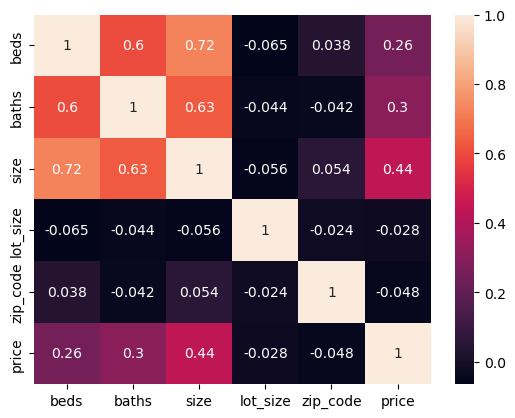

In [31]:
corr_train = df.corr(numeric_only = False)
sns.heatmap(corr_train, annot = True)

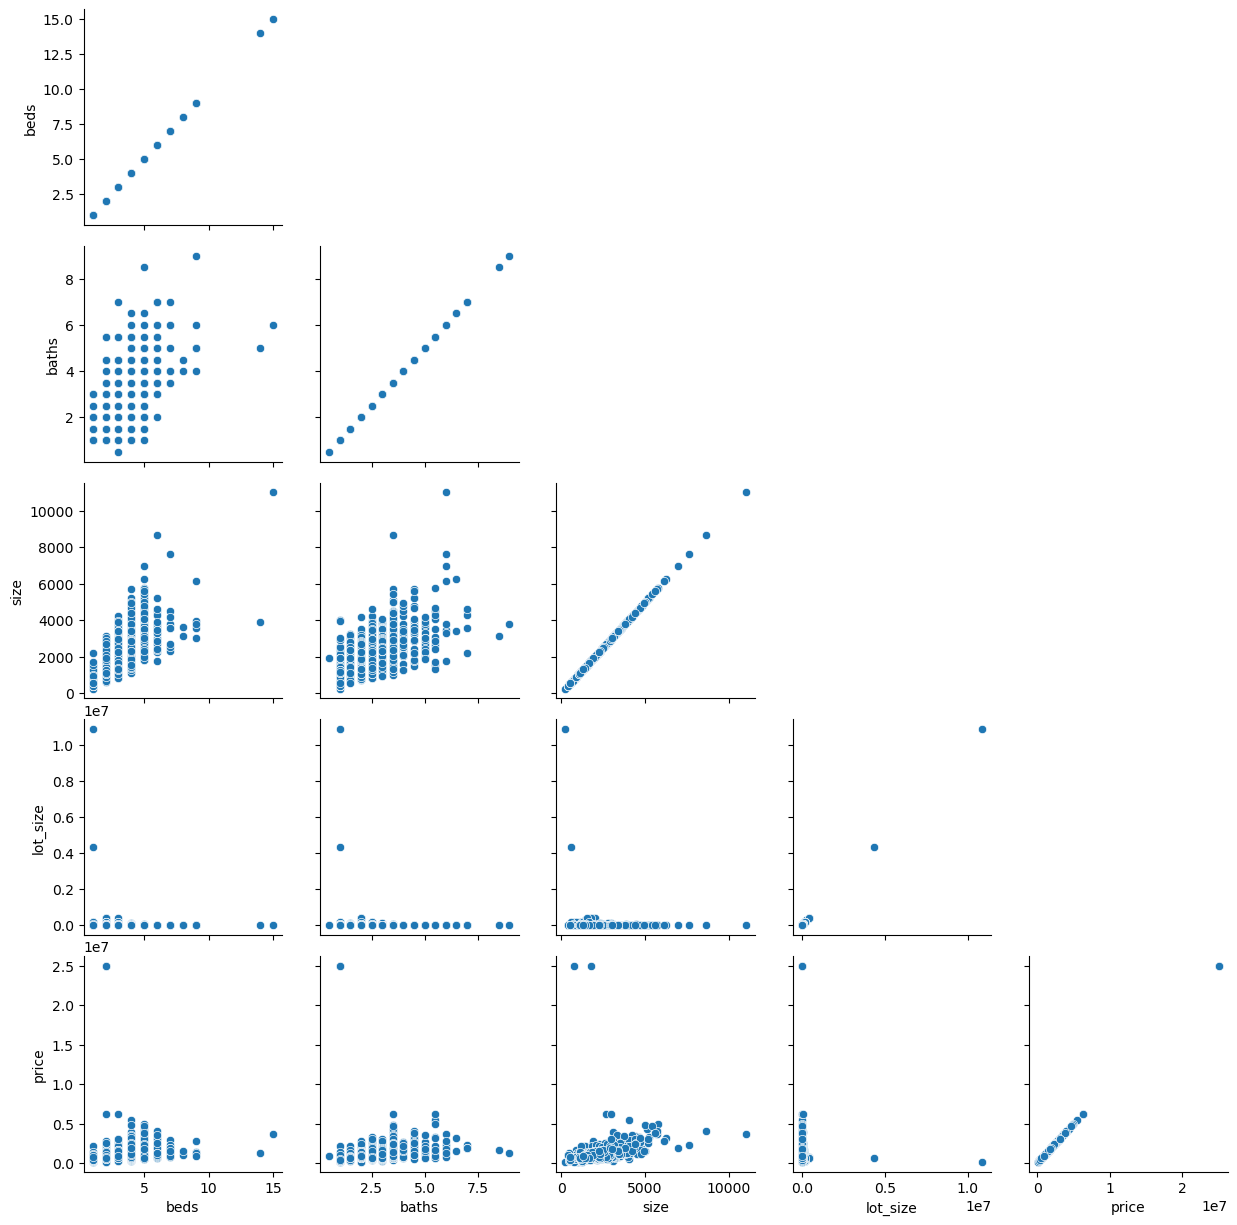

In [32]:
g = sns.PairGrid(df, corner = True)
g.map(sns.scatterplot)

Признак с наиболее выраженной зависимостью - это площадь дома, проиллюстрируем его:

In [33]:
fig = px.scatter(df,
          x = 'size',
          y = 'price',
          labels = {'size': 'Total floor area', 'price': 'Price of the property'})
fig.update_layout(title = 'Floor area vs. Final price')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 0 to 504
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   beds      2097 non-null   int64   
 1   baths     2097 non-null   float64 
 2   size      2097 non-null   float64 
 3   lot_size  2097 non-null   float64 
 4   zip_code  2097 non-null   category
 5   price     2097 non-null   float64 
dtypes: category(1), float64(4), int64(1)
memory usage: 101.6 KB


Разобъём признаки на категориальные и числовые:

In [38]:
df.drop(columns = 'zip_code')

,beds,baths,size,lot_size,price
0,3,2.50,2590.00,6000.00,795000.00
1,4,2.00,2240.00,13503.60,915000.00
2,4,3.00,2040.00,3783.00,950000.00
3,4,3.00,3800.00,5175.00,1950000.00
5,2,2.00,1190.00,43560.00,740000.00
...,...,...,...,...,...
500,5,4.50,5580.00,13068.00,3800000.00
501,3,2.50,1390.00,1570.00,575000.00
502,3,2.50,2950.00,20473.20,3105000.00
503,5,5.00,3010.00,4887.00,1807000.00


In [56]:
scaler_num = StandardScaler()
scaled_data = scaler_num.fit_transform(df.drop(columns = 'zip_code'))
scaled_data

array([[-0.11681823,  0.19252625,  0.73593296, -0.04194574, -0.26006435],
       [ 0.73376454, -0.30223789,  0.35335887, -0.01275913, -0.13258664],
       [ 0.73376454,  0.68729038,  0.1347451 , -0.05056916, -0.09540564],
       ...,
       [-0.11681823,  0.19252625,  1.12943774,  0.01435039,  2.19388159],
       [ 1.58434731,  2.66634693,  1.19502187, -0.04627496,  0.81499768],
       [-0.11681823, -0.30223789, -0.67303277, -0.05361478, -0.15383292]])

In [55]:
df['zip_code']

0      98144
1      98106
2      98107
3      98199
5      98107
       ...  
500    98146
501    98126
502    98118
503    98115
504    98103
Name: zip_code, Length: 2097, dtype: category
Categories (28, int64): [98101, 98102, 98103, 98104, ..., 98177, 98178, 98188, 98199]

In [49]:
scaler_cat = OneHotEncoder()

scaled_cat = scaler_cat.fit_transform(df['zip_code'])
scaled_cat

ValueError: Expected 2D array, got 1D array instead:
array=[98144 98106 98107 ... 98118 98115 98103].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Обучение моделей и предсказания на их основе

Выделим из обучающей и тестовой выборки искомую величину - стобец с продажными ценами:

In [45]:
X_train = train_df.drop(columns = ['price'], axis = 1)
y_train = train_df['price']

In [46]:
X_test = test_df.drop(columns = ['price'])
y_test = test_df['price']

Создадим словарь различных моделей машинного обучения:

In [79]:
regressors = {'Linear Regression': linear_model.LinearRegression(), 
              'Decision Tree': DecisionTreeRegressor(), 
              'Random Forest': RandomForestRegressor(n_estimators = 150, criterion = 'friedman_mse'),
              'Ridge (L2)' : linear_model.Ridge(alpha = 1),
              'Lasso (L1)' : linear_model.Lasso(alpha = 5)}

Пройдёмся циклом по словарю с моделями и выведем среднюю квадратичную ошибку и R2.

In [78]:
for name, model in regressors.items():
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    MSE = metrics.mean_squared_error(y_test, y_predict, squared = False)
    R2 = metrics.r2_score(y_test, y_predict)


    print(f'{name} has MSE = {MSE:.0f} and R2 = {R2:.2f}')

Linear Regression has MSE = 441111 and R2 = 0.49
Decision Tree has MSE = 1302669 and R2 = -3.44
Random Forest has MSE = 651847 and R2 = -0.11
Ridge (L2) has MSE = 441115 and R2 = 0.49
Lasso (L1) has MSE = 441112 and R2 = 0.49
Stochastic Descent has MSE = 3374334993490248192 and R2 = -29791455520392219310686208.00


В результате получаем, что наилушим образом, в данном случае, себя показала классическая линейная регрессия, однако её точность остаётся крайне низкой, а ошибка крайне высокой.